In [130]:
!pip3 install pydotplus
!pip3 install graphviz
!pip3 install scikit-plot

In [131]:
import statistics 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
import scikitplot as skplt
#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image
#confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

#GaussianNB

from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


## Load dataset

In [31]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Adding player's rank

In [32]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181501 entries, 0 to 185763
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          181501 non-null  object 
 1   tourney_name        181501 non-null  object 
 2   surface             181354 non-null  object 
 3   draw_size           181501 non-null  float64
 4   tourney_level       181501 non-null  object 
 5   tourney_date        181501 non-null  object 
 6   match_num           181501 non-null  float64
 7   winner_id           181501 non-null  float64
 8   winner_entry        25298 non-null   object 
 9   winner_name         181501 non-null  object 
 10  winner_hand         181501 non-null  object 
 11  winner_ioc          181501 non-null  object 
 12  winner_age          178681 non-null  float64
 13  loser_id            181501 non-null  float64
 14  loser_entry         43307 non-null   object 
 15  loser_name          181501 non-nul

C:\Users\Gerlando\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')
print(player, '\n# of nan:', player['rank'].isna().sum())

                   name    rank
0         AARON ADDISON  1037.0
1         AARON ADDISON  1254.0
2         AARON ADDISON  1255.0
3         AARON ADDISON  1047.0
4         AARON ADDISON  1055.0
...                 ...     ...
257926  ZUZANA ZLOCHOVA   343.0
257927  ZUZANA ZLOCHOVA   335.0
257928  ZUZANA ZLOCHOVA   316.0
257929  ZUZANA ZLOCHOVA   318.0
257930  ZUZANA ZLOCHOVA   316.0

[257931 rows x 2 columns] 
# of nan: 7622


In [34]:
#osserviamo quanti giocatori hanno QUALCHE nan
nan_name = player[player['rank'].isna()]
nan_name['name'].nunique()

763

In [35]:
#prendiamo la media del rank e vediamo se sono rimasti nan (per quelli che avranno nan come rank vuol dire che nel db originale 
# non era presente nessun valore di rank per quel giocatore)
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2037.000000
mean      490.356406
std       327.419749
min         3.000000
25%       243.000000
50%       422.000000
75%       682.000000
max      1908.000000
Name: rank, dtype: float64

In [36]:
player.isna().sum()

rank    35
dtype: int64

In [37]:
player['rank'].nunique()

947

In [38]:
player[player['rank'].isna()]

,rank
name,
ABIR EL FAHIMI,NaN
ALEX LAWSON,NaN
AMAL SULTANBEKOV,NaN
AMARNI BANKS,NaN
ANASTASIA IAMACHKINE,NaN
ANNA BOWTELL,NaN
BARBORA PALICOVA,NaN
BREANA STAMPFLI,NaN
CHARLOTTE KEMPENAERS POCZ,NaN


In [39]:
player.reset_index(inplace = True)
player

,name,rank
0,AARON ADDISON,1131.0
1,ABBIE MYERS,475.0
2,ABHINAV SANJEEV SHANMUGAM,1233.0
3,ABIGAIL TERE APISAH,422.0
4,ABIR EL FAHIMI,NaN
...,...,...
2067,ZIZOU BERGS,371.0
2068,ZOE HIVES,319.0
2069,ZOE KRUGER,750.0
2070,ZSOMBOR PIROS,454.0


In [40]:
df = pd.merge(df, player, how='left', on='name')

df.describe()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.00000,2037.000000
mean,0.486609,100.942085,0.478162,23.541988,0.309913,1993.805502,179.104946,80.432832,6.716569,0.523839,871.927124,7.450516,43.113605,6.698571,6.355497,54.31431,490.356406
std,0.115073,78.005562,0.134808,26.280039,0.264866,5.063032,8.008870,16.122646,5.324856,0.146481,720.860044,3.444339,12.302156,4.583606,1.962237,19.24605,327.419749
min,0.133333,0.000000,0.000000,0.000000,0.000000,1977.000000,157.000000,55.472222,0.000000,0.037581,0.000000,0.000000,0.000000,0.070000,0.000000,0.91000,3.000000
25%,0.423077,28.000000,0.415466,0.000000,0.000000,1990.000000,173.000000,62.607850,2.400000,0.505333,230.000000,5.220000,40.770000,2.550000,5.390000,39.42750,243.000000
50%,0.500000,82.000000,0.500000,12.000000,0.375000,1994.000000,178.000000,82.359127,5.755000,0.580575,638.500000,6.950000,47.295000,6.155000,6.615000,64.30500,422.000000
75%,0.565673,170.000000,0.566866,45.000000,0.533333,1998.000000,185.705882,94.008066,9.840000,0.614162,1446.500000,9.172500,50.112500,10.312500,7.552500,69.80000,682.000000
max,0.845161,309.000000,1.000000,101.000000,1.000000,2006.000000,198.000000,145.073643,35.390000,0.949992,3834.000000,29.860000,94.180000,23.310000,17.890000,80.79000,1908.000000


In [41]:
#POSSIAMO PROCEDERE IN diversi MODI:
# 1.cerchiamo di risolvere i nan 
# 2. lasciamo i giocatori che hanno nan e assegniamo loro un label speciale (non è insolito, bisogna vedere meglio come trattarli)
# 3. altro


## Transform categorical features into numerical ones

In [42]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [43]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [44]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   num_matches_2016-2019  2072 non-null   float64
 2   ratio_2016-2019        2072 non-null   float64
 3   num_matches_2020-2021  2072 non-null   float64
 4   ratio_2020-2021        2072 non-null   float64
 5   birth                  2072 non-null   float64
 6   ht                     2072 non-null   float64
 7   minutes                2072 non-null   float64
 8   perc_ace               2072 non-null   float64
 9   serv_won_tot_seve      2072 non-null   float64
 10  bpFaced                2072 non-null   float64
 11  perc_df                2072 non-null   float64
 12  perc_2ndwon            2072 non-null   float64
 13  perc_v_ace             2072 non-null   float64
 14  perc_v_df              2072 non-null   float64
 15  perc

## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli.

Nota: questa non è una metrica efficate perchè il vero label del giocatore viene calcolato in base al relativo ranking ma nel nostro caso avendo molti null risulta difficile stimarlo quindi se non ci sono altre alternative potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili

In [46]:
df.sort_values(by=['rank'])

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank,hand_num,gender_num,ioc_num
1493,0.845161,229.0,0.829694,81.0,0.888889,1987.0,188.000000,118.034749,10.43,0.675834,1454.0,4.92,54.72,11.15,6.01,65.42,3.0,1,1,78
1782,0.754579,232.0,0.745690,41.0,0.804878,1991.0,168.000000,88.797710,4.19,0.590683,1808.0,5.50,48.38,4.38,7.17,58.06,3.0,1,0,71
1617,0.835616,235.0,0.842553,57.0,0.807018,1986.0,185.000000,122.658811,7.35,0.679608,1377.0,3.69,57.72,12.03,5.78,64.74,3.0,0,1,26
1672,0.828829,202.0,0.841584,20.0,0.700000,1981.0,185.000000,112.136728,17.50,0.712798,874.0,3.41,58.48,10.92,5.65,68.16,4.0,1,1,80
1021,0.699405,270.0,0.711111,66.0,0.651515,1992.0,184.000000,97.553718,15.94,0.618893,2185.0,7.84,45.59,7.41,8.34,63.85,7.0,1,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0.133333,15.0,0.133333,0.0,0.000000,1999.0,172.137193,97.307692,3.15,0.391993,159.0,9.15,36.12,2.83,5.98,54.02,NaN,2,0,49
1701,0.379310,8.0,0.375000,21.0,0.380952,2002.0,177.500000,61.904040,3.20,0.409342,305.0,12.49,31.81,0.08,0.49,5.00,NaN,2,0,27
1833,0.500000,16.0,0.500000,0.0,0.000000,1994.0,173.363636,59.750000,0.00,0.130994,72.0,5.81,13.16,1.44,2.89,11.19,NaN,2,0,29
1866,0.380952,21.0,0.380952,0.0,0.000000,1994.0,172.137193,71.658654,0.72,0.482784,139.0,10.25,43.84,1.65,8.06,25.41,NaN,2,0,52


In [47]:
# label tipo1
quantile_a = df['rank'].quantile(0.25)


In [48]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [49]:
df = df.drop(df[df['rank'].isna()].index)


In [50]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [51]:
class_names = ['high-level', 'low-level']

In [52]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.746686
0    0.253314
Name: labels, dtype: float64

### Prepare dataset (splitting)

In [53]:
del df['rank']

In [54]:
#use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
#of label in train and test set 
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

In [55]:
np.size(train_label)

1527

# Classification 

## Classfication with decision tree

### Grid Search

In [56]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    }


#define the grid search
dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, 
                            scoring=make_scorer(accuracy_score))

In [62]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 38, 'splitter': 'random'}
              precision    recall  f1-score   support

  high-level       0.87      0.85      0.86       387
   low-level       0.95      0.96      0.95      1140

    accuracy                           0.93      1527
   macro avg       0.91      0.90      0.91      1527
weighted avg       0.93      0.93      0.93      1527

              precision    recall  f1-score   support

  high-level       0.72      0.74      0.73       129
   low-level       0.91      0.90      0.91       381

    accuracy                           0.86       510
   macro avg       0.82      0.82      0.82       510
weighted avg       0.86      0.86      0.86       510



In [58]:
blind_pred_dt = dt_grid.predict(blindtest)

In [89]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [103]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png()) AGGIUSTARE


digraph Tree {
node [color="black", fontname=helvetica, shape=box, style="filled, rounded"];
edge [fontname=helvetica];
0 [fillcolor="#7cbeee", label="X[10] <= 495.786\nentropy = 0.817\nsamples = 1527\nvalue = [387, 1140]\nclass = 1"];
1 [fillcolor="#3e9fe6", label="X[1] <= 23.101\nentropy = 0.164\nsamples = 665\nvalue = [16, 649]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#3a9de5", label="X[17] <= 0.449\nentropy = 0.031\nsamples = 314\nvalue = [1, 313]\nclass = 1"];
1 -> 2;
3 [fillcolor="#3c9ee5", label="X[7] <= 66.67\nentropy = 0.108\nsamples = 70\nvalue = [1, 69]\nclass = 1"];
2 -> 3;
4 [fillcolor="#399de5", label="entropy = 0.0\nsamples = 60\nvalue = [0, 60]\nclass = 1"];
3 -> 4;
5 [fillcolor="#4fa8e8", label="entropy = 0.469\nsamples = 10\nvalue = [1, 9]\nclass = 1"];
3 -> 5;
6 [fillcolor="#399de5", label="entropy = 0.0\nsamples = 244\nvalue = [0, 244]\nclass = 1"];
2 -> 6;
7 [fillcolor="#42a1e6", label="X[5] <= 1991.362\nentropy = 

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix


In [105]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
### PUò ESSERE UTILE CALCOLARE LA PROBABILITà DI APPARTENZA DI UN RECORD AD UNA CLASSE O ALL'ALTRA (UTILE PER ROC CURVE)
print(classification_report(train_label, train_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.87      0.85      0.86       387
   low-level       0.95      0.96      0.95      1140

    accuracy                           0.93      1527
   macro avg       0.91      0.90      0.91      1527
weighted avg       0.93      0.93      0.93      1527



In [106]:
print(classification_report(test_label, test_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.72      0.74      0.73       129
   low-level       0.91      0.90      0.91       381

    accuracy                           0.86       510
   macro avg       0.82      0.82      0.82       510
weighted avg       0.86      0.86      0.86       510



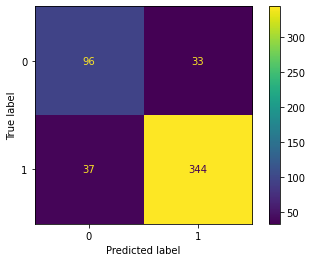

In [111]:
cm = confusion_matrix(test_label, test_pred_dt)
plot_confusion_matrix(dt_grid, test_set, test_label)
plt.show() 

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

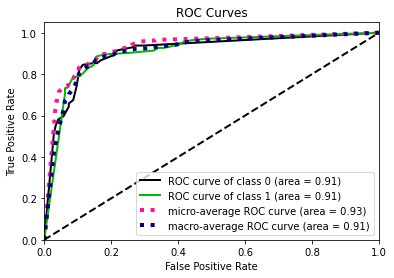

In [133]:
test_pred_proba_dt = dt_grid.predict_proba(test_set)
skplt.metrics.plot_roc(test_label, test_pred_proba_dt)

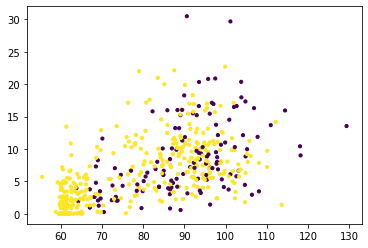

In [112]:
#ace and minutes
plt.scatter(test_set['minutes'], test_set['perc_ace'], c=test_label, s=10);

## Bayesian classifier

In [134]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [114]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [115]:
#compute the performance of the model
print(classification_report(train_label, train_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.68      0.93      0.79       387
   low-level       0.97      0.86      0.91      1140

    accuracy                           0.87      1527
   macro avg       0.83      0.89      0.85      1527
weighted avg       0.90      0.87      0.88      1527



In [116]:
print(classification_report(test_label, test_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.62      0.89      0.73       129
   low-level       0.96      0.82      0.88       381

    accuracy                           0.84       510
   macro avg       0.79      0.86      0.81       510
weighted avg       0.87      0.84      0.85       510



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

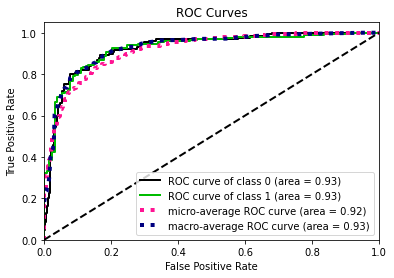

In [132]:
test_pred_proba_gnb = gnb.predict_proba(test_set)
test_pred_proba_gnb
skplt.metrics.plot_roc(test_label, test_pred_proba_gnb)

### 